In [1]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

#summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt

# Create Gaussian blurs with different widths

In [14]:
n_perclass = 1000
img_size = 91
x = np.linspace(-4,4,img_size)
X,Y = np.meshgrid(x,x)

#the two widths (arbitrary units HERE)
widths = [1.8,2.4]
images = torch.zeros(2*n_perclass,1,img_size,img_size)
labels = torch.zeros(2*n_perclass)

for i in range(2*n_perclass):

    #create the gaussian with random centres
    ro = 2*np.random.rand(2)  #ro = random offeset
    G = np.exp( -( (X-ro[0])**2+ (Y-ro[1])**2) /  (2*widths[i%2]**2) )

    #and add noise now
    G = G + np.random.rand(img_size,img_size)/5

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)
    labels[i] = i%2

labels = labels[:,None]

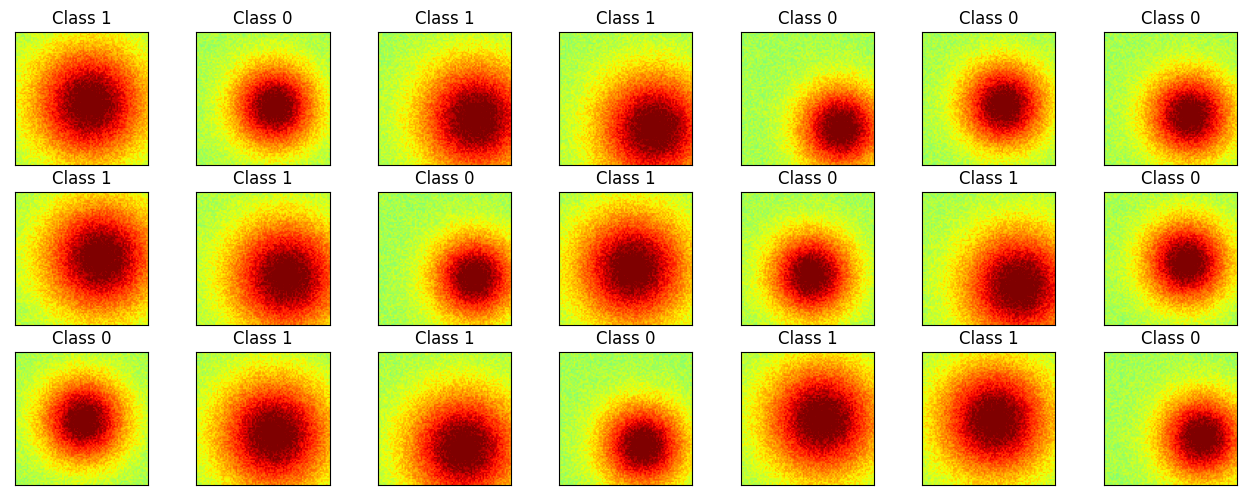

In [16]:
fig,axs = plt.subplots(3,7,figsize=(16,6),dpi=100)

for i,ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(2*n_perclass)
    G = np.squeeze( images[which_pic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_title("Class %s"%int(labels[which_pic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Create train/test group using DataLoader

In [18]:
#step 2: use scikitlearn to split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

#step 3: convert into pytorch Datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

#Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [19]:
#checking the size, should be images x channels x height x width
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)

torch.Size([1340, 1, 91, 91])
torch.Size([660, 1, 91, 91])


# Create the DL model

In [25]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,1),             # output size: 1
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [28]:
#test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
y_hat = net(X)
print(y_hat.shape)
loss = lossfun(y_hat,y)
print(" ")
print("loss")
print(loss)

torch.Size([32, 1])
 
loss
tensor(0.6879, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [32]:
#count the toal number of parameters in the model
summary(net,(1,img_size,img_size))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Create a function to train the model

In [36]:
# a function that trains the model

def function_to_train():
    #number of epochs
    n_epochs = 10

    #create a new model
    net,lossfun,optimizer = makeTheNet()

    #initialize losses
    train_loss = torch.zeros(n_epochs)
    test_loss = torch.zeros(n_epochs)
    train_acc = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #loop over epochs
    for epochi in range(n_epochs):

        #loop over training data batches
        batch_loss = []
        batch_acc = []
        for X,y in train_loader:
            #forward pass and loss
            y_hat = net(X)
            loss = lossfun(y_hat,y)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss from this batchs
            batch_loss.append(loss.item())
            batch_acc.append(   torch.mean((    (y_hat>.5) == y).float()).item()    )
        #end of batch loop

        #getting the averages over batches
        train_loss[epochi] = np.mean(batch_loss)
        train_acc[epochi] = 100*np.mean( batch_acc)

        #test accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_hat = net(X)
            loss = lossfun(y_hat,y)

        #test accuracies
        test_loss[epochi] = loss.item()
        test_accuracy[epochi] = 100*torch.mean((    (y_hat>.5)==y ).float()).item()
    #end of epochs

    #function output
    return train_loss,test_loss,train_acc,test_accuracy,net

# Run the model and get the results!

In [37]:
train_loss,test_loss,train_acc,test_accuracy,net = function_to_train()

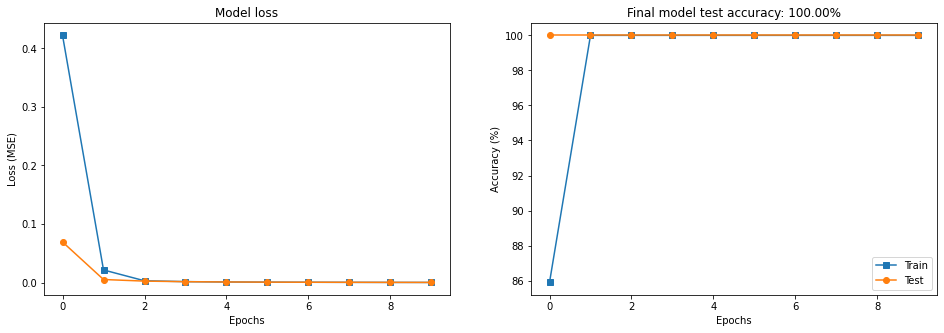

In [38]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(test_loss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(test_accuracy,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_accuracy[-1]:.2f}%')
ax[1].legend()

plt.show()

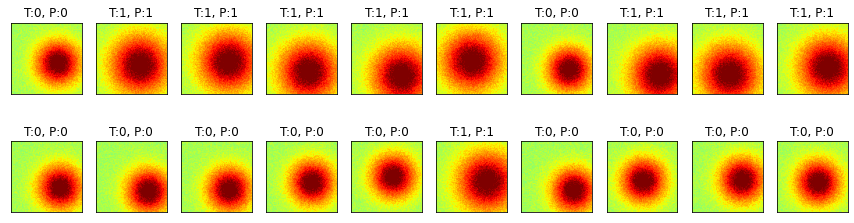

In [39]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [40]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


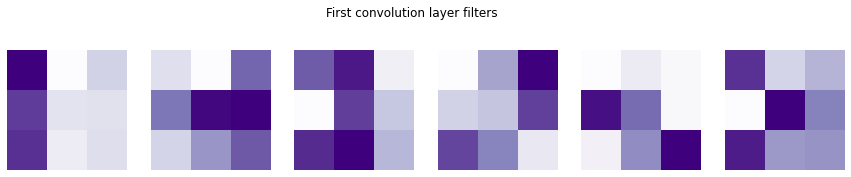

In [41]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

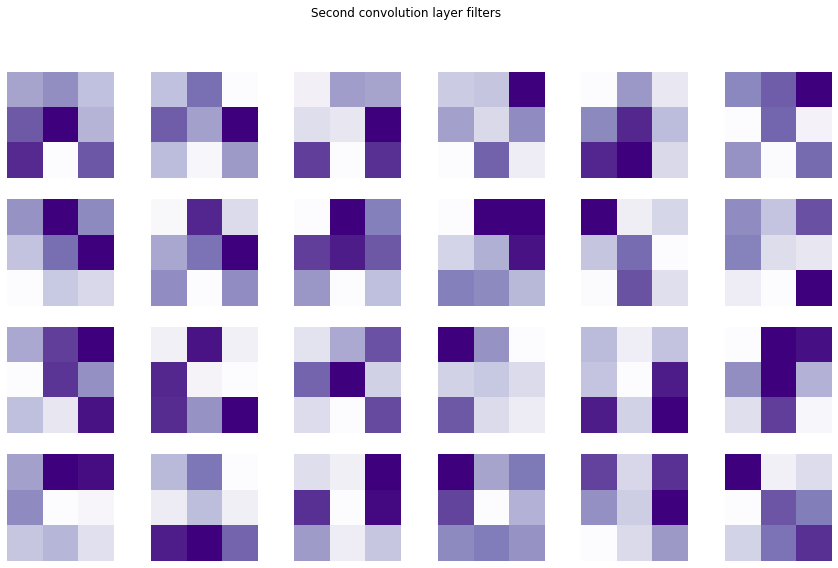

In [42]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()